# Stage 3. Crisis Detector: Classification to Relevant and Non-Relevant Tweets

In [1]:
import pandas as pd
from termcolor import colored
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sms

In [11]:
lemma = WordNetLemmatizer()
STOPWORDS=set(stopwords.words('english')+list(punctuation))
STOPWORDS.remove("not")

In [12]:
data=pd.read_csv('Cleaned.csv')

In [13]:
data.head()

,TweetsID,RawTweets,Cleaned_Tweets,User_Location,Date
0,62c025362199f17ae64a6e30,The insurance industry has an opportunity to d...,the insurance industry has an opportunity to d...,"London, UK",Sat Jul 02 11:00:00 +0000 2022
1,62c02a912199f17ae64a6e39,A good perspective on the #Russia fake narrati...,a good perspective on the russia fake narrativ...,Worldwide,Sat Jul 02 11:22:52 +0000 2022
2,62c02a9e2199f17ae64a6e3b,@MU53701477 @abipittbull @Renehaehnlein @Ljudm...,user_mention user_mention user_mention user_me...,NaN,Sat Jul 02 11:23:05 +0000 2022
3,62c02ad82199f17ae64a6e3d,Latest Russia-Ukraine War: Live Updates https:...,latest russiaukraine war live updates URL late...,NaN,Sat Jul 02 11:24:03 +0000 2022
4,62c031185dcb23acdffbcf2d,"@EU_Commission @ua_parliament Today, the most ...",user_mention user_mention today the most impor...,NaN,Sat Jul 02 11:50:43 +0000 2022


In [14]:
tweets=classify()

In [15]:
tweets[0]

{'TweetsID': '62c025362199f17ae64a6e30',
 'RawTweets': 'The insurance industry has an opportunity to develop ’affirmative physical damage offerings’\nhttps://t.co/keH0CIswZV\n@LloydsofLondon\n #Cambridgecentreofriskstudies\n#RussiaUkraine #Cyber #Risk #GeopoliticalRisk',
 'Cleaned_Tweets': 'the insurance industry has an opportunity to develop affirmative physical damage offerings URL user_mention cambridgecentreofriskstudies russiaukraine cyber risk geopoliticalrisk ',
 'User_Location': 'London, UK',
 'Date': 'Sat Jul 02 11:00:00 +0000 2022',
 'Baseline_Terms': ['damage', 'risk'],
 'Prediction': 1}

In [16]:
clasifiedTweetsClass=pd.DataFrame(tweets) # Converting list to Dataframes

In [19]:
clasifiedTweetsClass.head(2)

,TweetsID,RawTweets,Cleaned_Tweets,User_Location,Date,Baseline_Terms,Prediction
0,62c025362199f17ae64a6e30,The insurance industry has an opportunity to d...,the insurance industry has an opportunity to d...,"London, UK",Sat Jul 02 11:00:00 +0000 2022,"[damage, risk]",1
1,62c02a912199f17ae64a6e39,A good perspective on the #Russia fake narrati...,a good perspective on the russia fake narrativ...,Worldwide,Sat Jul 02 11:22:52 +0000 2022,[],0


In [20]:
Tweet_count =clasifiedTweetsClass['Prediction'].value_counts()
Tweet_count

1    5948
0    3001
Name: Prediction, dtype: int64

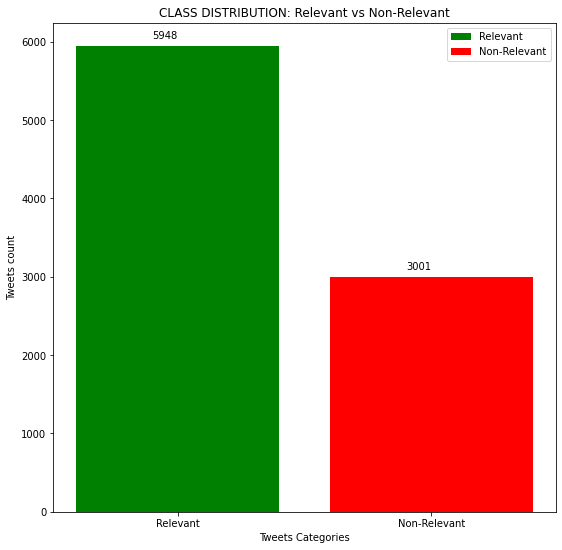

In [21]:
plot_barchat()

In [22]:
classified_Tweets=clasifiedTweetsClass.copy()

In [23]:
relevant_Tweets=classified_Tweets[classified_Tweets['Prediction']==1] #Extracting only relevants tweets

In [24]:
relevant_Tweets.head(2)

,TweetsID,RawTweets,Cleaned_Tweets,User_Location,Date,Baseline_Terms,Prediction
0,62c025362199f17ae64a6e30,The insurance industry has an opportunity to d...,the insurance industry has an opportunity to d...,"London, UK",Sat Jul 02 11:00:00 +0000 2022,"[damage, risk]",1
2,62c02a9e2199f17ae64a6e3b,@MU53701477 @abipittbull @Renehaehnlein @Ljudm...,user_mention user_mention user_mention user_me...,,Sat Jul 02 11:23:05 +0000 2022,[please],1


In [25]:
clasifiedTweetsClass.to_csv('classifiedTweets2.csv', index = False) #Saving classified Tweets to CSV File

In [26]:
relevant_Tweets.to_csv('relevantTweets.csv', index = False) #Saving relevat Tweets to CSV File

##  Corresponding functions used in above Classifier

In [3]:
#1. Function classifying Tweets as Relevant or Non-Relevant

In [2]:
def classify():
    lex_WORDS_FILE = 'CrisisLexRec.txt'
    lex_words = file_to_wordset()
    #set(open(lex_WORDS_FILE).read().split('\n'))
    predictions = []
    
    with open('Tweets2.csv', 'r',encoding="utf8") as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        lex1=[]
        
        for line in reader:
            lex={}
            TweetsID,RawTweets,Cleaned_Tweets,User_Location,Time_Created= line
            lex['TweetsID']=str(TweetsID)
            lex['RawTweets']=RawTweets
            lex['Cleaned_Tweets']=Cleaned_Tweets
            lex['User_Location']=User_Location
            lex['Date']=Time_Created
        # ignore retweets 
            pos_count=0
            if lex['Cleaned_Tweets'].startswith('RT') or len(lex['Cleaned_Tweets']) < 4:
                pass 
            else:
                word=lemmatize_text(lex['Cleaned_Tweets'])
                found_words=[]
                for words in word:                                   
                    if words in lex_words:
                        found_words.append(words)
                        pos_count += 1
                # saving crisis terms found and overall classification of the tweet
                lex['Baseline_Terms']=found_words
                lex['Prediction'] = 1 if pos_count >=1 else 0
                lex1.append(lex)
        return lex1

In [4]:
#2.  Function for lemmatizing Tweets words

In [7]:
def lemmatize_text(tweets):  
    tweets = word_tokenize(tweets)
    valid_Words=[]
    for word in tweets :
        if word in STOPWORDS or word=='URL' or word=='user_mention' or word=='hurricanelaura' or word=='amp'or word=='delta'or word=='louisiana' or word=='laura' or word=='hurricane' or word=='zeta' or word=='hurricanedelta'or word=='amp' or word=='dsnap' or word=='gtgt' or 'hurricane' in word or word=='…' :continue
        valid_Words.append(word)
        tweets=[lemma.lemmatize(word) for word in valid_Words]
    return tweets

In [6]:
#3. Dictionary of Crisis words

In [8]:
def file_to_wordset():
    ''' Converts a file with a word per line to a Python set '''
    words1 = []
    with open('CrisisLexRec.txt', 'r',encoding="utf8") as f:
        for line in f:
            words = word_tokenize(line)
            word=[lemma.lemmatize(word) for word in words]
            for words in word:
                #print(words)
            #words.append(line.strip())
                words1.append(words)
    return set(words1)

In [9]:
#4. Bar chat of Relevant vs Non-Relevant

In [10]:
def plot_barchat():
    plt.figure(figsize = (9, 9))
    plt.bar(['Relevant', 'Non-Relevant'], Tweet_count.values, color = ['g', 'r'])
    for i, v in enumerate(Tweet_count.values):
        plt.text(i - 0.1, v + 100, str(v))
        plt.xlabel("Tweets Categories")
        plt.ylabel("Tweets count")
        plt.title("CLASS DISTRIBUTION: Relevant vs Non-Relevant")
        plt.savefig('compare_class.png')
        colors = {'Relevant':'green', 'Non-Relevant':'red'}
        labels = list(colors.keys())
        handles = plt.bar(['Relevant', 'Non-Relevant'], Tweet_count.values, color = ['g', 'r'])
        plt.legend(handles,labels)